In [173]:
import numpy as np
import matplotlib.pyplot as plt
import math

np.random.seed(42)

### Функция для работы с .jpg - определение черных и белых пикселей в rgb пространстве

In [174]:
def is_black(rgb):
  return rgb[0] == rgb[1] == rgb[2] == 0

def is_white(rgb):
  return rgb[0] == rgb[1] == rgb[2] == 255

### Исходное изображение

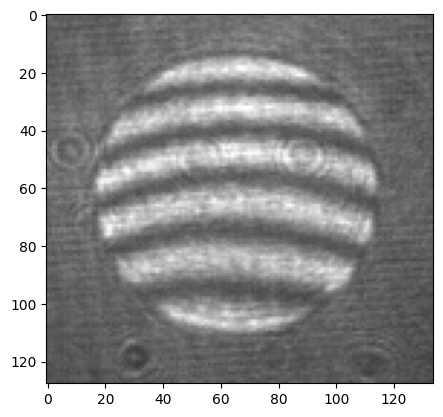

In [175]:
im = plt.imread('int.jpg')

plt.imshow(im)
plt.show()

In [176]:

# создание бинарного изображения по некоторому уровню "яркости" пикселей (работает только с .bmp)
# for bmp
# level = 150
# binary = im > level
# plt.imshow(binary)
# plt.show()

### Функция для создания бинарного изображения по уровню factor = сумма значений компонент rgb

In [177]:
def contrast (im, factor):
    #for jpg
    im2 = np.copy(im)

    for y in range(len(im2)):
        for x in range(len(im2[0])):
            current = im2[y][x]
            current_sum = sum(current)
            im2[y][x] = [0, 0, 0] if current_sum < factor else [255, 255, 255]
    return im2

### Создание бинарного изображения для определения размеров окружности, описанной вокруг интерферограммы

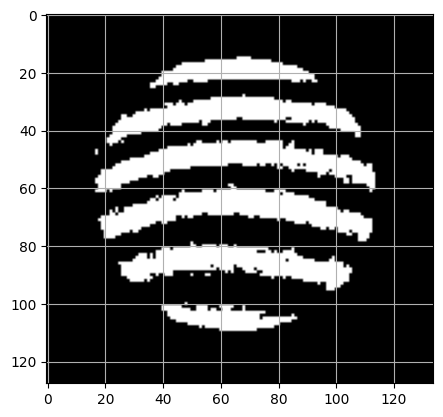

In [178]:
im2 = contrast(im, 460) #значение factor берется большим, чтобы гарантированно исключить засветы вокруг интерферограммы
plt.imshow(im2)
plt.grid()
plt.show()

### Определение центра и радиуса интерферограммы

In [179]:
top = left = (len(im2[0]), len(im2)) 
right = bottom = (0, 0)
for y in range(len(im2)):
    for x in range(len(im2[0])):
        current = im2[y][x]
        current_sum = sum(current)
        if current_sum > 0:
            if y < top[1]: top = (x, y)
            if y > bottom[1]: bottom = (x, y)
            if x < left[0]: left = (x, y)
            if x > right[0]: right = (x, y)

#print(top, left, right, bottom, sep=' ')
center_x = (left[0]+right[0])//2
center_y = (top[1]+bottom[1])//2
center = (center_x, center_y)
R = max(abs(right[0] - center_x), abs(bottom[1] - center_y))
print(center, R)

(65, 62) 48


### Показать вычисленный центр интерферограммы на рисунке

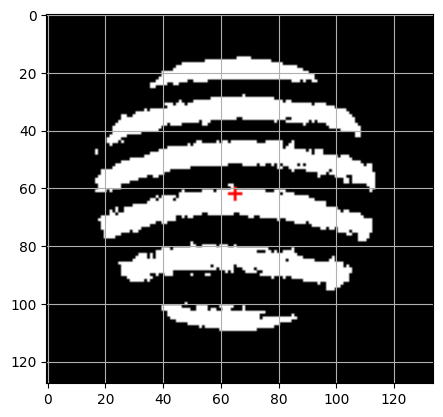

In [180]:
#center mark
color = [255, 0, 0]
im3 = np.copy(im2)
im3[center_y][center_x] = color
im3[center_y + 1][center_x] = color
im3[center_y - 1][center_x] = color
im3[center_y][center_x + 1] = color
im3[center_y][center_x - 1] = color
im3[center_y + 2][center_x] = color
im3[center_y - 2][center_x] = color
im3[center_y][center_x + 2] = color
im3[center_y][center_x - 2] = color
plt.imshow(im3)
plt.grid()
plt.show()

### Построение окружности, описывающей интерферограмму

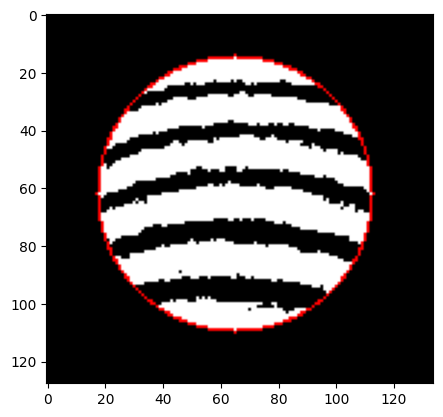

In [181]:
im4 = contrast(im, 380) #значение factor берется меньшим, чтобы не потерять информацию о форме интерференционных полос
im4_1 = np.copy(im4)
# plt.imshow(im4)
# plt.show()

for y in range(len(im4)):
    for x in range(len(im4[0])):
        dist = math.dist(center, (x, y))
        if dist > R:                        #убирает "мусор" вне окружности
            im4[y][x] = [0, 0, 0]
            im4_1[y][x] = [0, 0, 0]
        elif (1 > R - dist >= 0):           #построение окружности на рисунке
            im4[y][x] = [255, 0, 0]

plt.imshow(im4)
plt.show()

### Определение верхних точек интерференционных полос для аппроксимации

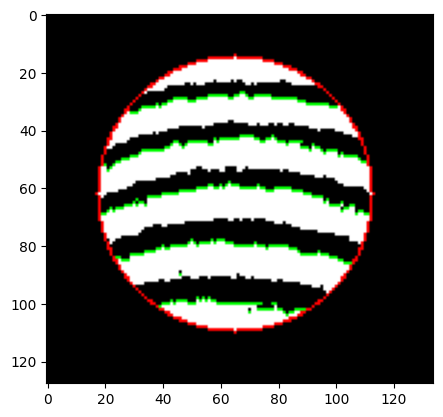

In [182]:
im5 = np.copy(im4)

curves_points = []

#если выбранная точка белая, а точка над ней черная - запомнить и отметить
for y in range(len(im5)):
  for x in range(len(im5[0])):
    is_prev_black = False if y == 0 else is_black(im5[y - 1][x])
    is_curr_white = is_white(im5[y][x])

    if is_prev_black and is_curr_white:
      im5[y][x] = [0, 255, 0]
      curves_points.append([x, y])

plt.imshow(im5)
plt.show()

### Получение информации о кривых интерферограммы

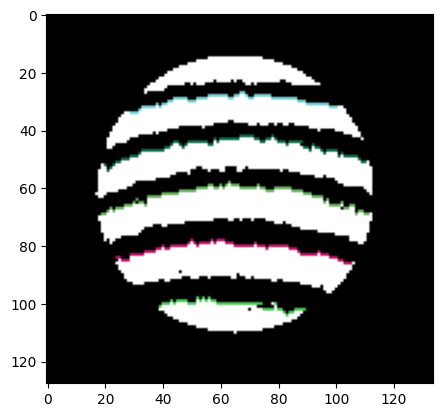

In [183]:
x_sorted_curves_points = sorted(curves_points, key=lambda p: p[0])
# print(x_sorted_curves_points)

# берется самая левая белая точка и ищется ближайшая к ней белая точка до тех пор, пока точек не останется
# когда вычисление кривой закончено, точки этой кривой удаляются из общего массива точек
def get_curve():
  fp = x_sorted_curves_points.pop(0)

  curve = [fp]

  if len(x_sorted_curves_points) == 0:
    return curve

  p = min(x_sorted_curves_points, key=lambda point: math.dist(point, fp))
  dist = math.dist(p, fp)

  #
  # настроить макисмальное растояние
  #
  while dist < 15:
    curve.append(p)
    x_sorted_curves_points.remove(p)

    x_closest = list(filter(lambda point: point[0] - curve[-1][0] == 1, x_sorted_curves_points))

    if len(x_closest) == 0:
      break

    p = min(x_closest, key=lambda point: math.dist(point, curve[-1]))
    dist = math.dist(p, curve[-1])
  
  return curve

im6 = np.copy(im4_1)

curves = [] # массив с координатами кривых

# убрать слишком короткие кривые, которые не должны участвовать в аппроксиммации
while len(x_sorted_curves_points) > 0:
  curve = get_curve()

  #
  # настроить минимальную длину
  #
  if len(curve) < 10:
    continue

  curves.append(curve)

  color = np.random.choice(range(0, 256), 3)
  for p in curve:
    im6[p[1]][p[0]] = color
    #im6[p[1] + 1][p[0]] = color
    # im6[p[1] - 1][p[0]] = color

plt.imshow(im6)
plt.show()

### Аппроксимация кривых интерферограммы с помощью МНК

          2
0.004688 x - 0.6106 x + 79.3
           3            2
6.479e-06 x + 0.003425 x - 0.5369 x + 78.07
            4             3            2
-2.433e-07 x + 6.974e-05 x - 0.002293 x - 0.3282 x + 75.53


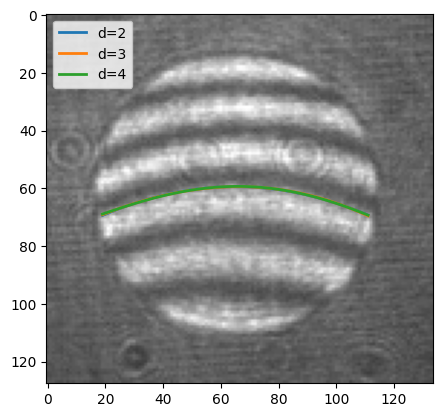

          2
0.004462 x - 0.6001 x + 63.07
            3            2
-3.522e-06 x + 0.005149 x - 0.6403 x + 63.76
           4             3            2
-5.41e-09 x - 2.115e-06 x + 0.005021 x - 0.6356 x + 63.7


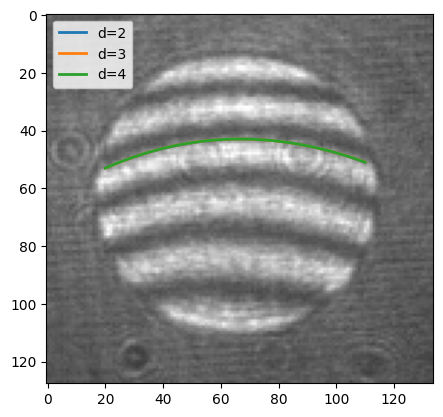

          2
0.003957 x - 0.4919 x + 94.32
            3           2
-1.723e-05 x + 0.00729 x - 0.6896 x + 97.82
            4             3           2
-1.704e-08 x - 1.283e-05 x + 0.00689 x - 0.6744 x + 97.62


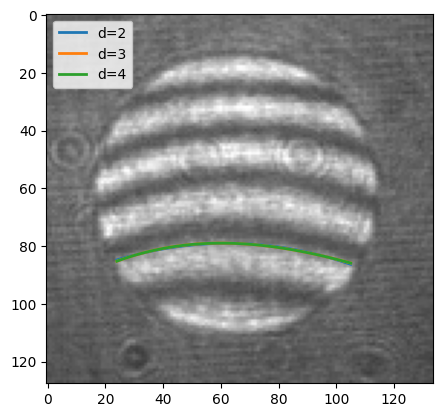

          2
0.004027 x - 0.5387 x + 46.03
            3            2
-1.356e-05 x + 0.006651 x - 0.6974 x + 48.99
           4             3            2
5.474e-08 x - 2.768e-05 x + 0.007957 x - 0.7483 x + 49.69


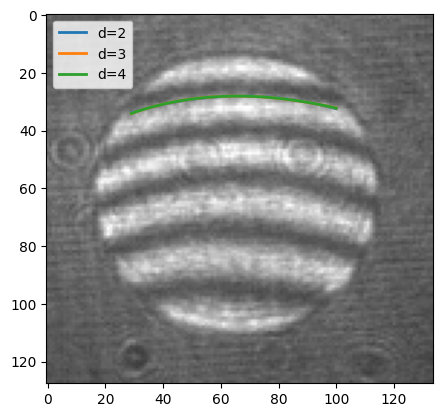

          2
0.002954 x - 0.3088 x + 107.4
           3           2
-0.000122 x + 0.02638 x - 1.76 x + 136.3
            4             3           2
-2.992e-06 x + 0.0006439 x - 0.04549 x + 1.164 x + 92.85


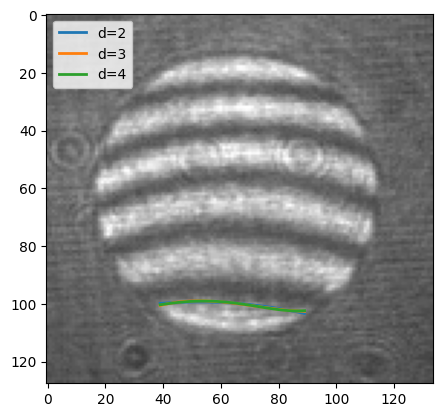

In [184]:
def poly(curve):
  x = list(map(lambda p: p[0], curve))
  y = list(map(lambda p: p[1], curve))

  legend = []
  for d in range(2, 5):
    fp, residuals, rank, sv, rcond = np.polyfit(x, y, d, full=True) # d - степень полинома

    f = np.poly1d(fp)

    print(f)
    plt.plot(x, f(x), linewidth=2)
    legend.append("d=%i" % f.order)


  plt.imshow(im)
  plt.legend(legend, loc="upper left")
  plt.show()

for i in range(len(curves)):
  poly(curves[i])